<font size=8> Network Tests


In [1]:
#Common Python Packages
from pickle import TRUE
import pickle
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *
from lib.dynapse2_raster import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product

#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs import neuron_configs_bio

# Determine the user's home directory
home_directory = os.path.expanduser("~")
# Path to the Documents directory
documents_path = os.path.join(home_directory, "Documents")
# Path to the dynapse-se2-data directory within Documents
save_directory_path = os.path.join(documents_path, "dynapse-se2-data")
# Path to the data
data_type_path = os.path.join(save_directory_path, "network_heatmaps")

<font size=8> Heatmaps Plotting

In [2]:
data_type_path = os.path.join(data_type_path, "Sweep_01")

<font size=6> Poisson PC PC


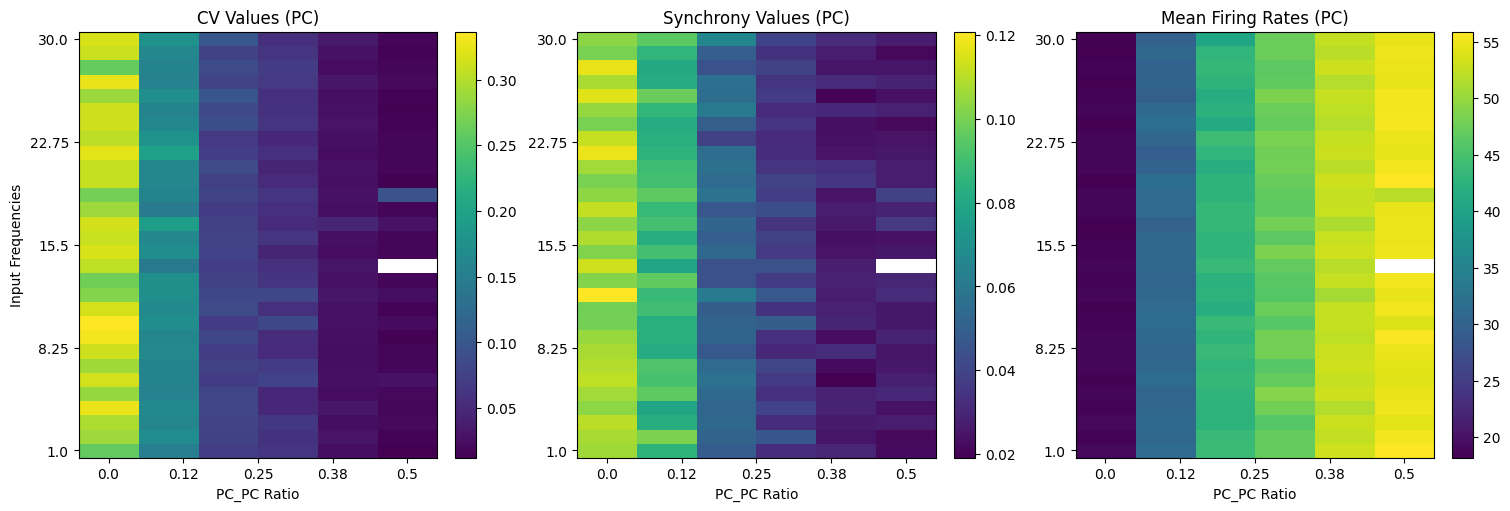

In [3]:
data_path_1 = os.path.join(data_type_path, "EI_sweep_PC_PC_poisson.npy")
data_1 = np.load(data_path_1, allow_pickle=True).item()
plot_heatmaps(data_1, 'PC_PC Ratio')

<font size=6> Poisson PC PV


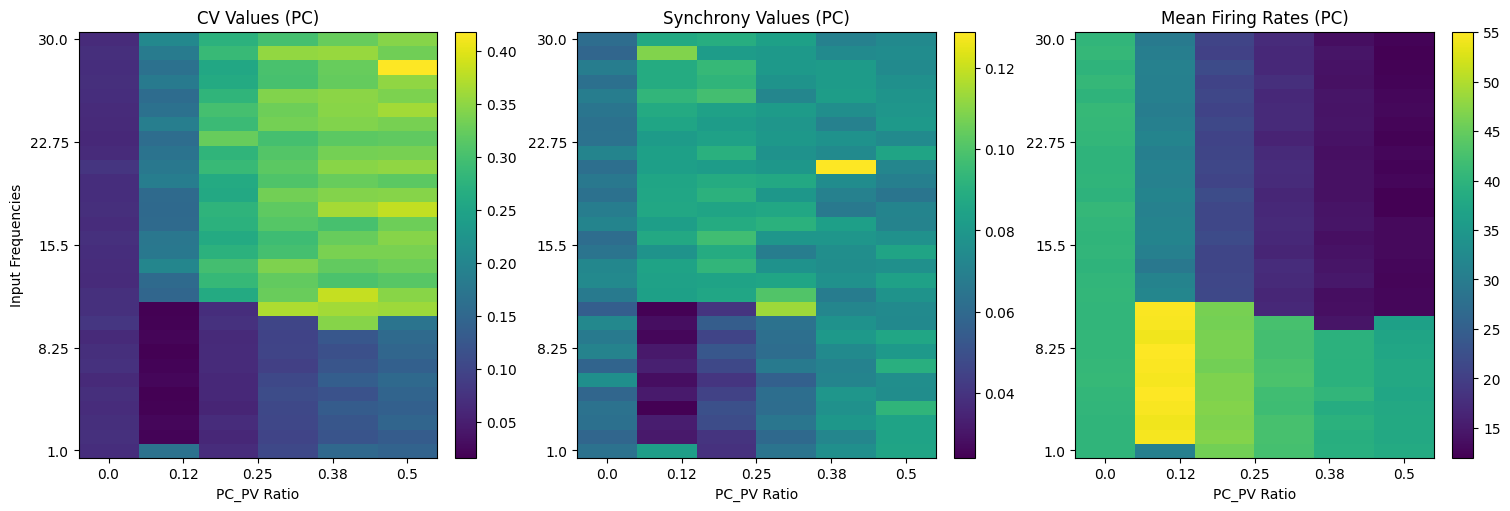

In [6]:
data_path_2 = os.path.join(data_type_path, "EI_sweep_PC_PV_poisson.npy")
data_2 = np.load(data_path_2, allow_pickle=True).item()
plot_heatmaps(data_2, 'PC_PV Ratio')

<font size=6> Regular PC PC


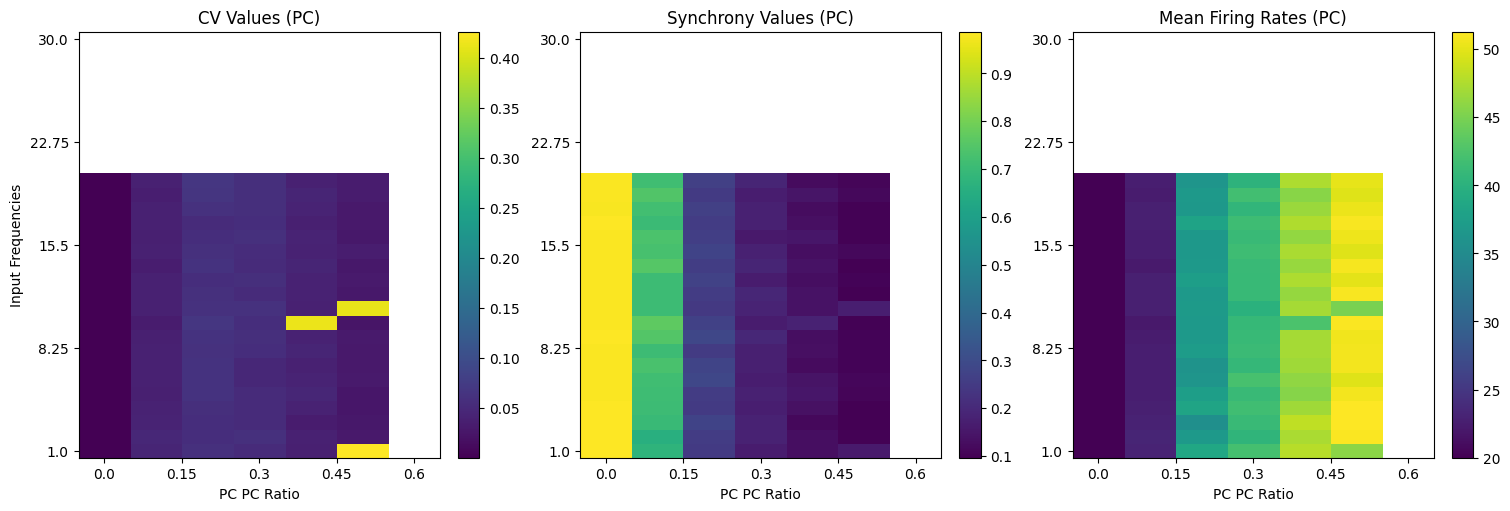

In [23]:
data_path_3 = os.path.join(data_type_path, "EI_sweep_PC_PC_regular.npy")
data_3 = np.load(data_path_3, allow_pickle=True).item()
plot_heatmaps(data_3, 'PC PC Ratio',ratiolimit=.6)


<font size=6> Regular PC PV


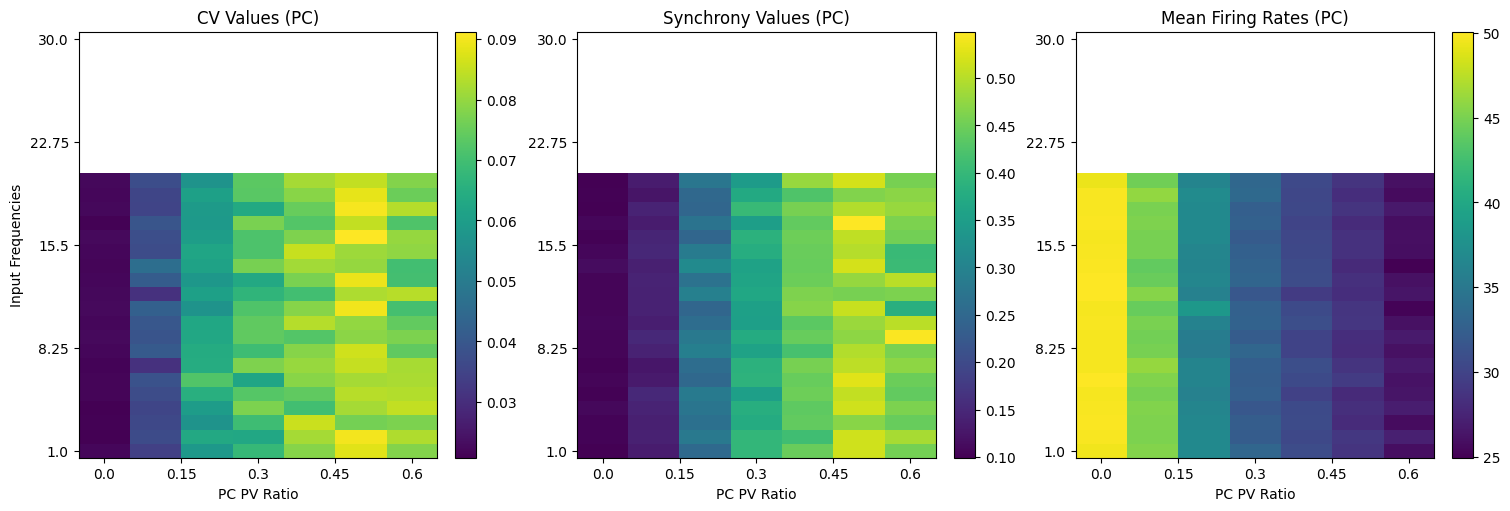

In [24]:
data_path_4 = os.path.join(data_type_path, "EI_sweep_PC_PV_regular.npy")
data_4 = np.load(data_path_4, allow_pickle=True).item()
plot_heatmaps(data_2, 'PC PV Ratio',ratiolimit=.6)



<font size=6> combined visualization

In [25]:
def plot_combined_heatmaps(data_dicts, xlabels, ytitles, tick_fontsize=10, title_fontsize=12, label_fontsize=10, colorbar_size=0.046, row_spacing=0.04, ratiolimit=.7):
    # Set the figure and GridSpec
    fig = plt.figure(figsize=(35, 10))
    width=5
    gs = gridspec.GridSpec(2, 10, width_ratios=[width, width, width, 0.0005, 0.0005, width, width, width, 0.00001, 0.00001])  # Add additional columns for spacing

    # Add this line to adjust the space between all subplots
    plt.subplots_adjust(wspace=0.4,hspace=0.3)

    # Titles for each column
    col_titles = ['CV Values', 'Synchrony Values', 'Mean Firing Rates', '', '', 'CV Values', 'Synchrony Values', 'Mean Firing Rates', '', '']

    # Set subplot titles and axis labels
    for i in range(2):
        for j in range(10):  # Adjust for additional columns
            ax = plt.subplot(gs[i, j])
            if i == 0:  # Set column titles for the first row
                ax.set_title(col_titles[j], fontsize=label_fontsize, pad=12)
            ax.set_xlabel(xlabels[i], fontsize=label_fontsize, labelpad=12)  # Set x-axis labels for every row based on the row index
            if j == 0 or j == 5: # Set y-axis labels for the first and sixth columns
                ax.set_ylabel('Input Frequencies', fontsize=label_fontsize, labelpad=10)

    # Set the titles for each row
    fig.text(0.285, .99, 'Regular Input Train', va='center', ha='center', fontsize=title_fontsize)
    fig.text(0.685, .99, 'Poisson Input Train', va='center', ha='center', fontsize=title_fontsize)

    # Plot heatmaps for each data dictionary
    for i, data in enumerate(data_dicts):
        # Create a mask to limit the data up to a certain connection ratio
        if ratiolimit < 1:
            mask = data['connection_ratios'] <= ratiolimit
            data['connection_ratios'] = data['connection_ratios'][mask]
            for key in ['cv_values_pc', 'synchrony_values_pc', 'mean_pc_rates']:
                data[key] = np.reshape(data[key], (len(data['input_frequencies']), len(data['connection_ratios'])))[mask]

        # Set the ticks for the x axis (same for each row)
        xticks = np.linspace(0, len(data['connection_ratios']) - 1, min(5, len(data['connection_ratios'])))
        xticklabels = np.round(np.linspace(data['connection_ratios'][0], data['connection_ratios'][-1], min(5, len(data['connection_ratios']))), 2)
        
        # Prepare data matrices
        matrices = [np.flipud(np.reshape(data[key], (len(data['input_frequencies']), len(data['connection_ratios'])))) for key in ['cv_values_pc', 'synchrony_values_pc', 'mean_pc_rates']]
        
        # Plot heatmaps
        for j, matrix in enumerate(matrices):
            ax = plt.subplot(gs[i//2, j + (i%2)*5])  # Adjust for additional columns
            cax = ax.matshow(matrix, interpolation='nearest', aspect='auto')
            # Add colorbars, adjusted if necessary
            fig.colorbar(cax, ax=ax, fraction=colorbar_size, pad=0.04)
            # Set the ticks for the x axis
            ax.xaxis.set_ticks_position('bottom')
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels, fontsize=tick_fontsize)
            # Set the ticks for the y axis
            yticks = np.linspace(0, len(data['input_frequencies']) - 1, min(5, len(data['input_frequencies'])))
            yticklabels = np.round(np.linspace(data['input_frequencies'][0], data['input_frequencies'][-1], min(5, len(data['input_frequencies'])))[::-1]).astype(int)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticklabels, fontsize=tick_fontsize)

    # Hide the fourth, fifth, ninth, and tenth columns (index 3, 4, 8, and 9) of each row
    for i in range(2):
        plt.subplot(gs[i, 3]).axis('off')
        plt.subplot(gs[i, 4]).axis('off')
        plt.subplot(gs[i, 8]).axis('off')
        plt.subplot(gs[i, 9]).axis('off')

    # Display the plot
    plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 30 but corresponding boolean dimension is 7

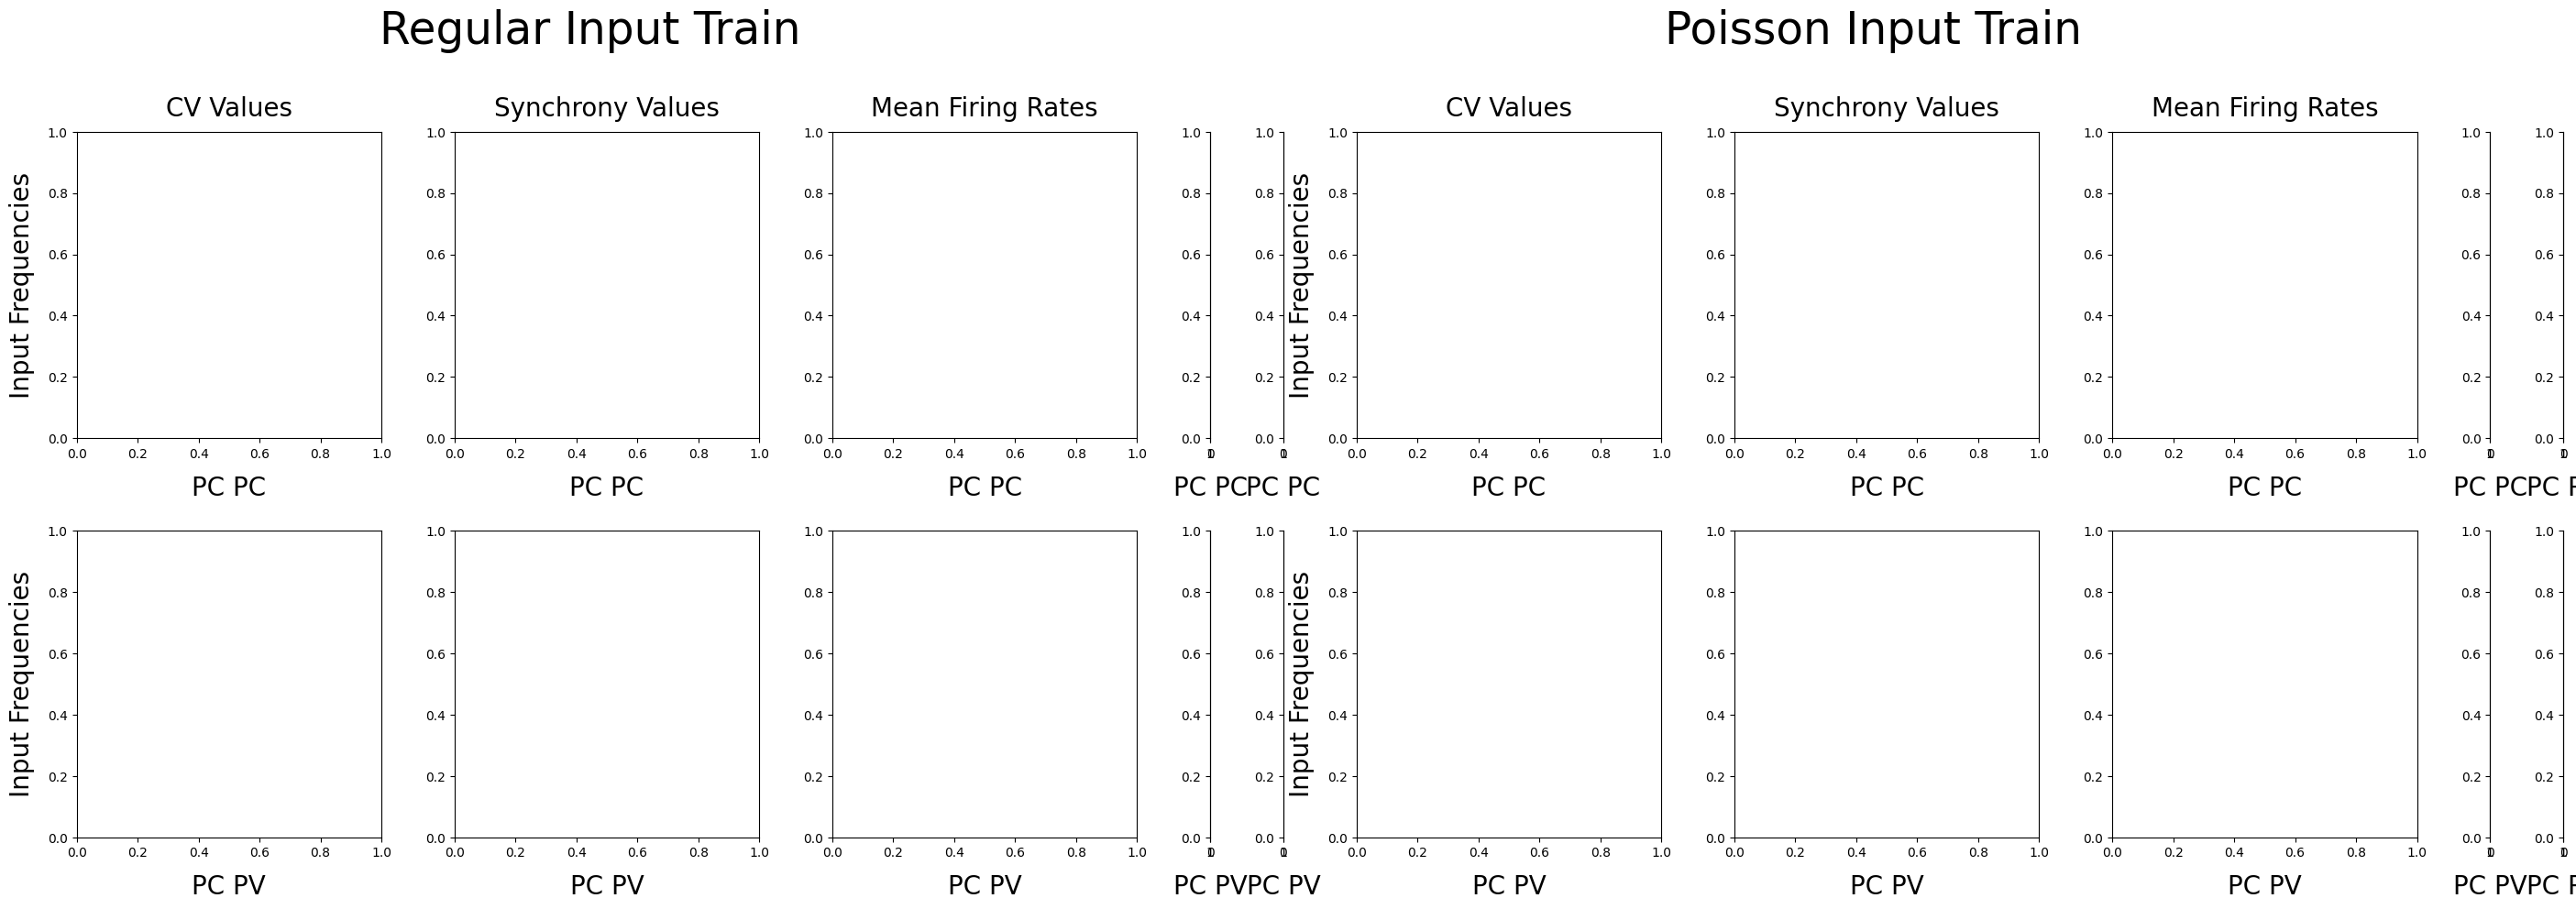

In [18]:
data_1=np.load(data_path_1, allow_pickle=True).item()
data_2=np.load(data_path_2, allow_pickle=True).item()
data_3=np.load(data_path_3, allow_pickle=True).item()
data_4=np.load(data_path_4, allow_pickle=True).item()
data_dicts = [data_1, data_2, data_3, data_4]
xlabels = ['PC PC', 'PC PV', 'PC PC', 'PC PV']
ytitles = ['Regular', 'Poisson']
plot_combined_heatmaps(data_dicts, xlabels, ytitles, tick_fontsize=12, title_fontsize=35, label_fontsize=20, colorbar_size=0.06, row_spacing=1)
